<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/main_analyses_mHPCsplit_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this copy of the notebook, I am using **neural similarity** (instead of dissimilarity) and I use a **Fisher transform** on the neural similarity matrix. The goal is to figure out why so many subjects cluster at the bottom near 0. Peter Dayan said there is probably something wrong with the model fitting.

# Introduction

This notebook uses the Julich atlas (threshold at prob>0.75) to segment data from Garvert et al. 2017 eLife.
We define hippocampal ROIs including Dentate Gyrus and Cornu Ammonis (no subiculum for now), and segment them according to y=-21 (as in Poppenk et al. 2013 eLife).
The main thing to change is in the section "Load beta map" (i.e. folder and path specification).

# Parameters

In [1]:
threshold = 50 # Threshold for the probabilistic atlas (there is a tradeoff between reliability and number of voxels
normalizeSR = True # Whether to use a row-normalized SR or not
ub = 100 # Bound for the model coefficients
metric = 'correlation' # Metric to use to measure neural similarity!!

## Install and import packages

In [2]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 100.4 MB/s eta 0:00:00


In [3]:
from nilearn import image
from nilearn import plotting, image, datasets
from nilearn.datasets import load_mni152_template
from nilearn.datasets import fetch_atlas_aal
import nibabel as nib
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import tempfile
import os
from PIL import Image
from copy import copy
from nilearn.image import resample_to_img
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from scipy.special import expit
from scipy.special import logit
from nilearn import plotting, image, datasets, masking
from scipy.stats import ttest_rel
from scipy.linalg import expm

## Functions

## Segmentation
Functions to segment the hippocampus along the x (left and right) and y (posterior and anterior) axes.

In [4]:
def segmentHippocampusX(mask, x_index):
  # This function segments the mask along the x axis, into left and right.
  # Note: mask is a 3D boolean array.
  # In the MNI, the midline corresponds to x=0. However, we need to convert it
  # into voxel coordinates.
  # The output is a dictionary with two keys (left and right).

  right = mask.copy() # I use copy to avoid getting views of variables
  left = mask.copy()

  right[:x_index,:,:] = 0
  # then y_index is set to 0 (and discarded)
  end = mask.shape[0]
  left[x_index:end,:,:] = 0

  return {'left': left,
          'right': right}


In [5]:
def segmentHippocampusY(mask, y_index_anterior, y_index_posterior):
    """
    Segment a hippocampal mask into anterior and posterior portions
    with an optional gap between y_index_posterior and y_index_anterior.

    Parameters
    ----------
    mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    y_index_anterior : int
        #Voxel index corresponding to the *start* of the anterior portion (e.g., y = -18).
    y_index_posterior : int
        #Voxel index corresponding to the *end* of the posterior portion (e.g., y = -24).

    Returns
    -------
    dict
        {'anterior': anterior_mask, 'posterior': posterior_mask}
    """
    anterior_mask = mask.copy()
    posterior_mask = mask.copy()

    end = mask.shape[1]

    # posterior: keep y < y_index_posterior
    posterior_mask[:, y_index_posterior:end, :] = 0

    # anterior: keep y > y_index_anterior
    anterior_mask[:, :y_index_anterior, :] = 0

    return {'posterior': posterior_mask,
            'anterior': anterior_mask}

In [6]:
#def segmentHippocampusY(mask, y_idx_post_end, y_idx_mid_end, y_idx_ant_start):
    #"""
    #Segment a hippocampal mask into posterior, middle, and anterior portions
    #along the y-axis (MNI convention: posterior < anterior).

    #Parameters
    #----------
    #mask : 3D boolean array
        #Full hippocampal mask in MNI space.
    #y_idx_post_end : int
        #Voxel index marking the *end* of the posterior portion (e.g., y = -30).
    #y_idx_mid_end : int
        #Voxel index marking the *end* of the middle portion (e.g., y = -19).
    #y_idx_ant_start : int
        #Voxel index marking the *start* of the anterior portion (e.g., y = -18).

    #Returns
    #-------
    #dict
        #{'posterior': posterior_mask,
         #'middle': middle_mask,
         #'anterior': anterior_mask}
    #"""
    #posterior_mask = np.zeros_like(mask)
    #middle_mask = np.zeros_like(mask)
    #anterior_mask = np.zeros_like(mask)

    # Fill each region based on y-axis voxel indices
    #posterior_mask[:, :y_idx_post_end, :] = mask[:, :y_idx_post_end, :]
    #middle_mask[:, y_idx_post_end:y_idx_mid_end, :] = mask[:, y_idx_post_end:y_idx_mid_end, :]
    #anterior_mask[:, y_idx_mid_end:y_idx_ant_start, :] = mask[:, y_idx_mid_end:y_idx_ant_start, :]

    #return {'posterior': posterior_mask,
            #'middle': middle_mask,
            #'anterior': anterior_mask}

## Loading data

In [7]:
def load_beta_images(run_dir, condition_ids):
    betas = []
    for cond_id in condition_ids:
        pattern = f"_object_{cond_id}_mean_beta.nii.gz" #alternative: _mean_beta_np.nii.gz (or f"_object_{cond_id}_mean_beta.nii.gz" or f"_concat_object_{cond_id}_beta.nii.gz")
        files = [f for f in os.listdir(run_dir) if pattern in f]
        assert len(files) == 1, f"Expected one match for {pattern}"
        img = nib.load(os.path.join(run_dir, files[0]))
        betas.append(img.get_fdata().flatten())  # flatten to 1D voxel vector
    return np.vstack(betas)  # shape (7, n_voxels)

In [8]:
def extractBetas(beta_img, mask_img):
  # This function take a .nii image from beta_img and from mask_imgs
  # it put them in the same reference frame and then use the latter as a boolean
  # mask
  # The function returns a vector with n elements, where n is the number of non-
  # zero elemnts in mask_img

  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)

  beta_data = beta_img.get_fdata()
  mask_data = resampled_mask_img.get_fdata()

  mask_bool = mask_data > 0  # Ensure mask is binary

  masked_betas = beta_data[mask_bool]
  return masked_betas

## Others

In [9]:
def computeSR(T, gamma, normalize=False):
  # This function computes the SR matrix from a transition matrix T
  # and a gamma value.
  # If normalize=True, SR will be row-normalized, making it alike probabilities
  I = np.eye(T.shape[0])
  difference = I - gamma * T
  # Compute the inverse of (I - gamma * T)
  M = np.linalg.inv(difference)
  if normalize:
    M = M / M.sum(axis=1, keepdims=True)
  return M

In [10]:
def computeDK(A, alpha):
  degrees = np.sum(A, axis=1)
  D = np.diag(degrees)
  L = D - A
  K = expm(-alpha * L)
  return K

In [11]:
def corr_triangles(M1, M2):
  # To correlate neural similarity and model similarity, we need to
  # discard the diagonal. We can't just use squareform because SR is not
  # symmetric necessarily
  M1 = M1[~np.eye(M1.shape[0], dtype=bool)]
  M2 = M2[~np.eye(M2.shape[0], dtype=bool)]
  return pearsonr(M1, M2)

In [12]:
offmask = ~np.eye(7, dtype=bool)

# Define ROIs
In this section the main things to decide are:


*   Probability threshold: Julich atlas is probablistic, so to get binary masks (where a voxel is assigned to 1 only if it belongs to the ROI) we need to threshold it. The value is chosen in line with previous studies (Barnavelli et al. 2025 Nat Commun) and it also corresponds to a sort of elbow in voxel reliability (there is a tradeoff between # of selected voxels and reliability)
*   ROI definition. For now, we define the hippocampus as DG + CA



## Load Juelich brain atlas

In [13]:
julich = datasets.fetch_atlas_juelich("prob-1mm")
julich_img = image.load_img(julich.maps)
julich_data = julich_img.get_fdata()
julich_labels = julich.labels

[fetch_atlas_juelich] Added README.md to /root/nilearn_data

[fetch_atlas_juelich] Dataset created in /root/nilearn_data/fsl

[fetch_atlas_juelich] Downloading data from https://www.nitrc.org/frs/download.php/12096/Juelich.tgz ...

[fetch_atlas_juelich]  ...done. (1 seconds, 0 min)

[fetch_atlas_juelich] Extracting data from /root/nilearn_data/fsl/5f0f3de71552237df29d0de14db5f8c8/Juelich.tgz...

[fetch_atlas_juelich] .. done.

In [14]:
CA_idx = julich_labels.index("GM Hippocampus cornu ammonis") - 1
DG_idx = julich_labels.index("GM Hippocampus dentate gyrus") - 1
#S_idx = julich_labels.index("GM Hippocampus subiculum") - 1

In [15]:
CA = (julich_data[..., CA_idx] > threshold)
DG = (julich_data[..., DG_idx] > threshold)
#S = (julich_data[..., S_idx] > threshold)

# This now returns a 3D boolean array
HP = CA | DG

/tmp/ipython-input-2003817921.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')
/tmp/ipython-input-2003817921.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')


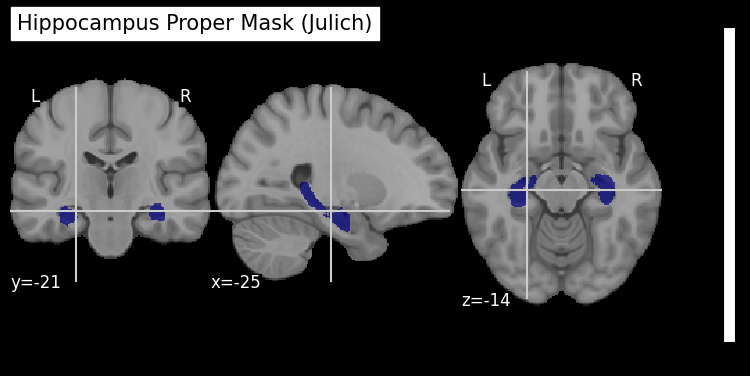

In [16]:
mni_img = datasets.load_mni152_template(resolution=1)

# Step 2: Convert your HP mask to a NIfTI image
hp_mask_img = nib.Nifti1Image(HP.astype(np.uint8), affine=julich_img.affine)

# Step 3: Resample the mask to match the MNI template (if needed)
hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')

# Step 4: Plot the mask over the MNI template
plotting.plot_roi(hp_mask_resampled, bg_img=mni_img, title="Hippocampus Proper Mask (Julich)", cut_coords=[-25,-21, -14])
plotting.show()

## Segment into left and right

In [17]:
mni_x = 0
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
x_index, _, _ = np.round(inv_affine @ np.array([mni_x, 0, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
sagittal_segmentation = segmentHippocampusX(HP, x_index)

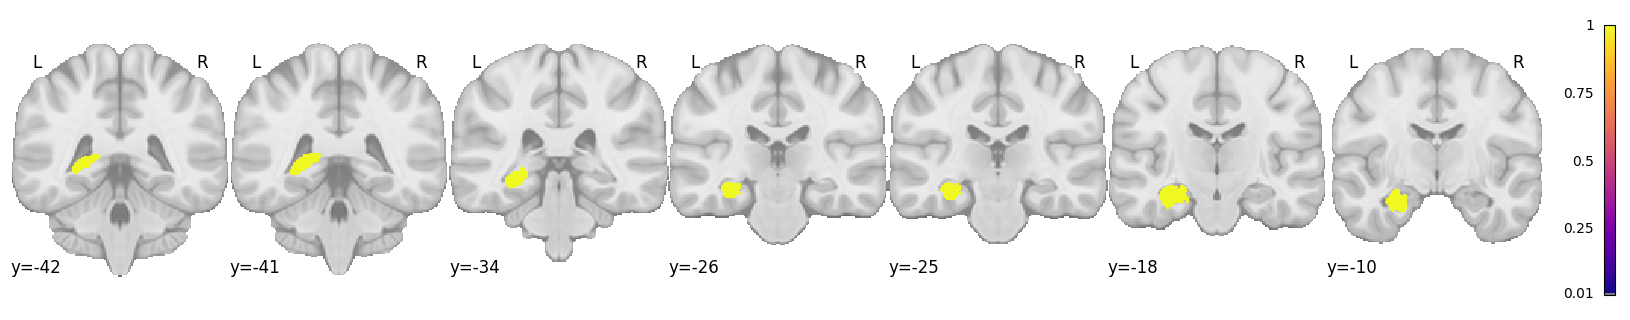

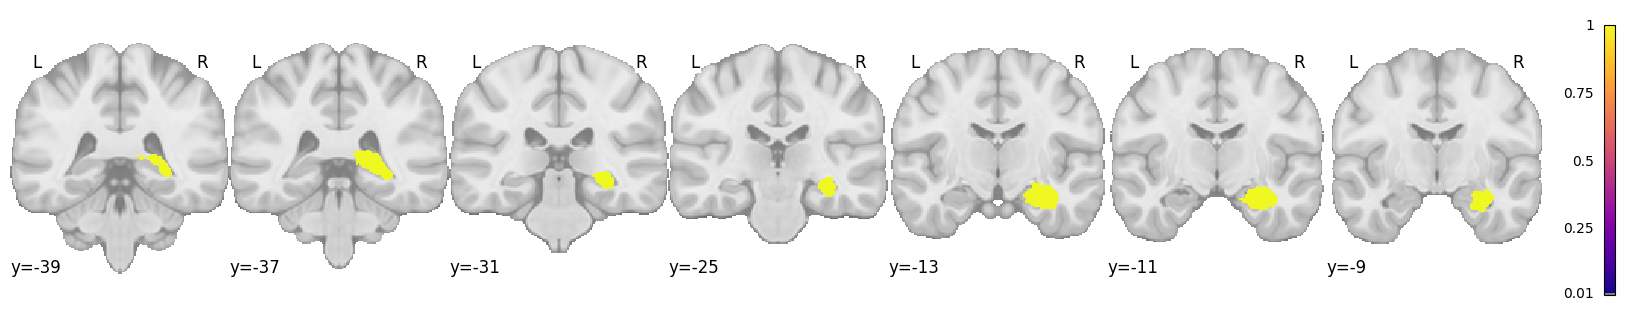

In [18]:
for h in sagittal_segmentation:
  plotting.plot_stat_map(
      nib.Nifti1Image(sagittal_segmentation[h].astype(np.uint8), affine),
      bg_img=mni_img,
      display_mode="y",
      draw_cross=False,
      threshold=0.01,
      black_bg=False,
      colorbar=True,
      cmap="plasma",
      vmin=0,
      vmax=1
  )
plotting.show()

## Segment into anterior and posterior

Because the data were smoothed with a 8mm FWHM Gaussian kernel, this means that for each voxel, within an 8mm span, there could be spatial autocorrelation! This is really important when specifying the boundaries for the anterior and posterior ROI parts. We want to take the y-coordinate of -21 to specify the anterior and posterior ROI boundaries (Brunec et al., 2018; Poppenk et al., 2013). Since the MNI coordinates are in mm, we decided to subtract 4 from -21, so -17 for the anterior boundary and -25 for the posterior boundary. Even though our "gap" is not a-priori justified, this is still a feasible and careful approach! :)

In [19]:
# Convert y = -14 and y = -28 MNI coordinates to voxel indices #those were the coordinates where I got statistically significant results for the two-tailed paired t-test before
mni_y = [-15, -27]  # new anterior/posterior boundaries
affine = julich_img.affine
inv_affine = np.linalg.inv(affine)  # transform MNI coordinates into matrix indices

# Compute voxel indices for both y values
_, y_index_anterior, _ = np.round(inv_affine @ np.array([0, mni_y[0], 0, 1])).astype(int)[:3]
_, y_index_posterior, _ = np.round(inv_affine @ np.array([0, mni_y[1], 0, 1])).astype(int)[:3]

# Fill masks: segment each hemisphere mask into anterior/posterior parts
masks = {
    h: segmentHippocampusY(seg, y_index_anterior, y_index_posterior)
    for h, seg in sagittal_segmentation.items()
}

# Convert each resulting ROI to a NIfTI image
masks_img = {
    h: {
        roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        for roi, arr in rois.items()
    }
    for h, rois in masks.items()
}

In [20]:
# ---------------------------------------------------------------------
# Segment each hemisphere mask (left/right) into posterior, middle, anterior according to the Pickatlas coordinates (Valerio)
# ---------------------------------------------------------------------

# Define MNI y-boundaries
# posterior: −40 to −30
# middle: −29 to −19
# anterior: −18 to −4
#mni_y = [-40, -30, -19, -4]

#affine = julich_img.affine
#inv_affine = np.linalg.inv(affine)

# Convert MNI y-values into voxel indices
#y_indices = []
#for y in mni_y:
    #_, y_idx, _ = np.round(inv_affine @ np.array([0, y, 0, 1])).astype(int)[:3]
    #y_indices.append(y_idx)

# Unpack voxel indices
#y_post_start, y_post_end, y_mid_end, y_ant_end = y_indices

# Segment each hemisphere along the y-axis into posterior, middle, and anterior
#masks = {
    #h: segmentHippocampusY(seg, y_post_end, y_mid_end, y_ant_end)
    #for h, seg in sagittal_segmentation.items()
#}

# Convert each resulting ROI to NIfTI images
#masks_img = {
    #h: {
        #roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        #for roi, arr in rois.items()
    #}
    #for h, rois in masks.items()
#}

#print("✅ Segmented hippocampus into left/right and posterior/middle/anterior subregions.")

In [21]:
#from nilearn import plotting
#import numpy as np

# Example: overlay left hemisphere masks with different colors
#plotting.plot_roi(masks_img['left']['posterior'], bg_img=mni_img, title='Left Hippocampus - Posterior', colorbar=False)
#plotting.plot_roi(masks_img['left']['middle'], bg_img=mni_img, title='Left Hippocampus - Middle', colorbar=False)
#plotting.plot_roi(masks_img['left']['anterior'], bg_img=mni_img, title='Left Hippocampus - Anterior', colorbar=False)
#plotting.show()

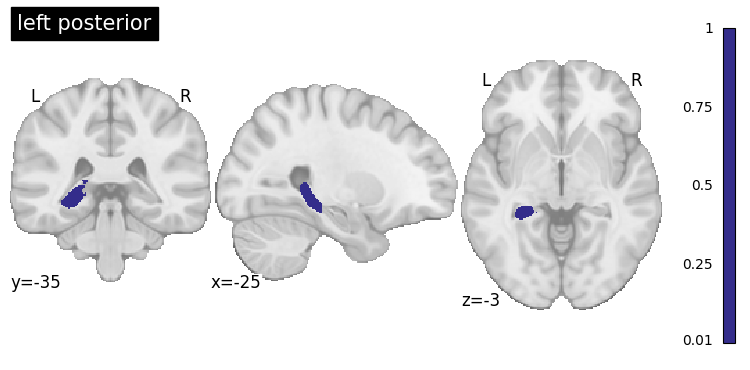

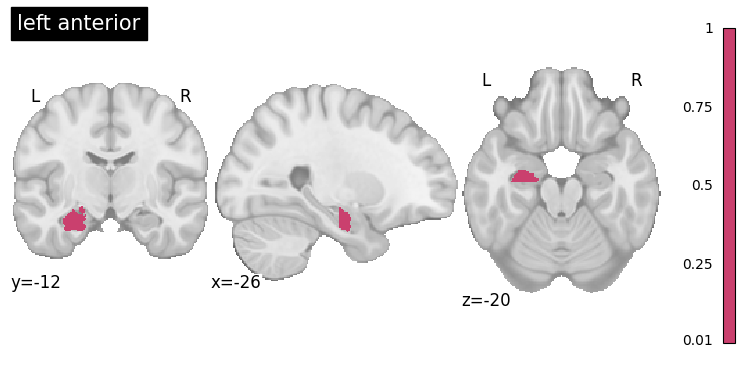

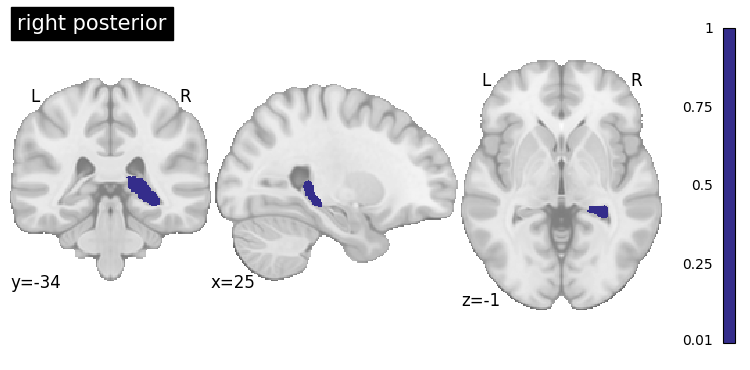

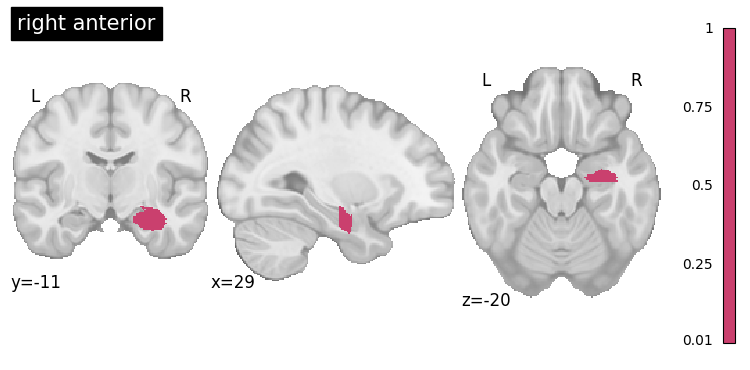

In [22]:
# Check: visualize the longitudinal axis segmentation
colors = {"posterior": '#342d8bff',
          "anterior": '#ca406eff'}
for h in masks_img:
  for roi in masks_img[h]:
    plotting.plot_stat_map(
        masks_img[h][roi],
        bg_img=mni_img,
        draw_cross=False,
        threshold=0.01,
        black_bg=False,
        colorbar=True,
        cmap=mcolors.ListedColormap([[0, 0, 0, 0], colors[roi]]),
        vmin=0,
        vmax=1,
        title=h + " " + roi
    )
  plotting.show()

# Load beta maps

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
# A-L's new version

import os
import numpy as np
import nibabel as nib

# Parameters
items = [2, 4, 6, 7, 8, 9, 10]
nItems = len(items)
nParticipants = 23
participants = np.arange(1, nParticipants + 1)

main_folder = "/content/drive/MyDrive/betas_allpatch/" #change to betas_nopatch
print(f"Loading mean beta maps from: {main_folder}")

# Load all mean beta maps
all_imgs = []  # nested list: [participant][item] = Nifti image

for subj_id in participants:
    subj_str = f"subject_{subj_id:02d}"
    subj_dir = os.path.join(main_folder, subj_str, "mean_betas") #change to mean_betas_np or to mean_betas or to concat_betas

    if not os.path.exists(subj_dir):
        print(f"Missing folder for {subj_str}, skipping.")
        continue

    subj_imgs = []
    for item in items:
        beta_filename = f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" #change to _mean_beta_np.nii.gz (or to f"sub-{subj_id:02d}_object_{item}_mean_beta.nii.gz" or f"sub-{subj_id:02d}_concat_object_{item}_beta.nii.gz")
        beta_path = os.path.join(subj_dir, beta_filename)

        if os.path.exists(beta_path):
            subj_imgs.append(nib.load(beta_path))
        else:
            print(f"Missing beta: {beta_filename}")
            subj_imgs = []  # Clear list if incomplete
            break  # skip participant if missing data

    if subj_imgs and len(subj_imgs) == nItems:
        all_imgs.append(subj_imgs)
        print(f"Loaded {len(subj_imgs)} betas for {subj_str}")
    else:
        print(f"Skipping {subj_str} (incomplete data)")

print(f"\nSuccessfully loaded mean betas for {len(all_imgs)} participants.")

Loading mean beta maps from: /content/drive/MyDrive/betas_allpatch/
Loaded 7 betas for subject_01
Loaded 7 betas for subject_02
Loaded 7 betas for subject_03
Loaded 7 betas for subject_04
Loaded 7 betas for subject_05
Loaded 7 betas for subject_06
Loaded 7 betas for subject_07
Loaded 7 betas for subject_08
Loaded 7 betas for subject_09
Loaded 7 betas for subject_10
Loaded 7 betas for subject_11
Loaded 7 betas for subject_12
Loaded 7 betas for subject_13
Loaded 7 betas for subject_14
Loaded 7 betas for subject_15
Loaded 7 betas for subject_16
Loaded 7 betas for subject_17
Loaded 7 betas for subject_18
Loaded 7 betas for subject_19
Loaded 7 betas for subject_20
Loaded 7 betas for subject_21
Loaded 7 betas for subject_22
Loaded 7 betas for subject_23

Successfully loaded mean betas for 23 participants.


# Extract betas for ROIs

In [25]:
# Slice the beta maps
# extractBetas extract the betas for the defined ROI
# Note: voxels is a list of nParticipants elements.
# Each element is a dictionary mirroring the structure of "mask_img", i.e.
# two keys (left and right), whose values have respectively two keys themselves
# (posterior and anterior).
# The voxels[p][hemisphere][posterior] is then the matrix of ROI responses to
# each of the seven items.

voxels = [
    {
        h: {
            roi: [extractBetas(item, masks_img[h][roi]) for item in subj]
            for roi in masks_img[h]
        }
        for h in masks_img
    }
    for subj in all_imgs
]

/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. 

In [26]:
# Ignore! Old, neural dissimilarity

#neural_DSMs = [
    #{
        #h: {
            #roi: squareform(pdist(np.asarray(subj[h][roi]), metric=metric))
            #for roi in subj[h]
        #}
        #for h in subj
    #}
    #for subj in voxels
#]

In [27]:
def fisher_z_clip(r, eps=1e-6):
    """
    Apply Fisher z-transform safely by clipping correlations
    to avoid ±1 -> ±inf issues.
    """
    r = np.clip(r, -1 + eps, 1 - eps)  # clip to [-0.999999, +0.999999]
    z = np.arctanh(r)
    return z

In [28]:
# Important! At a later step, the neural SIMILARITY matrices are Fisher transformed!

neural_NSMs = [  # Renamed variable from neural_DSMs to neural_NSMs
    {
        h: {
            # Change: Replace squareform(pdist(..., metric=metric)) with np.corrcoef(...)
            # np.asarray(subj[h][roi]) is a list of 7 arrays (one per object).
            # To correlate object patterns, we need the 7xN_voxels matrix.
            # np.corrcoef calculates the correlation between ROWS by default.
            # The input is already a list of 7 (object) arrays, so it will correctly
            # calculate the 7x7 correlation matrix between the object patterns.
            roi: np.corrcoef(np.asarray(subj[h][roi]))
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in voxels
]

In [29]:
# Ensure this step is run AFTER the cell that creates 'neural_NSMs'

neural_ZNSMs = [
    {
        h: {
            roi: fisher_z_clip(subj[h][roi])  # <---- uses your clipping function
            for roi in subj[h].keys() # Iterate over the ROI keys within the hemisphere
        }
        for h in subj.keys() # Iterate over the hemisphere keys
    }
    for subj in neural_NSMs
]

In [30]:
#from numpy import arctanh # arctanh is the same as atanh or Fisher Z-transform

# Ensure this step is run AFTER the cell that creates 'neural_NSMs'

#neural_ZNSMs = [ # Renaming to ZNSM to denote the transformed matrix
    #{
        #h: {
            #roi: arctanh(subj[h][roi]) # Apply the Fisher Z-transform element-wise
            #for roi in subj[h]
        #}
        #for h in subj
    #}
    #for subj in neural_NSMs # Use the newly created NSMs
#]

## Investigating values within neural similarity matrices

Text(0.5, 0, "Pearson's r")

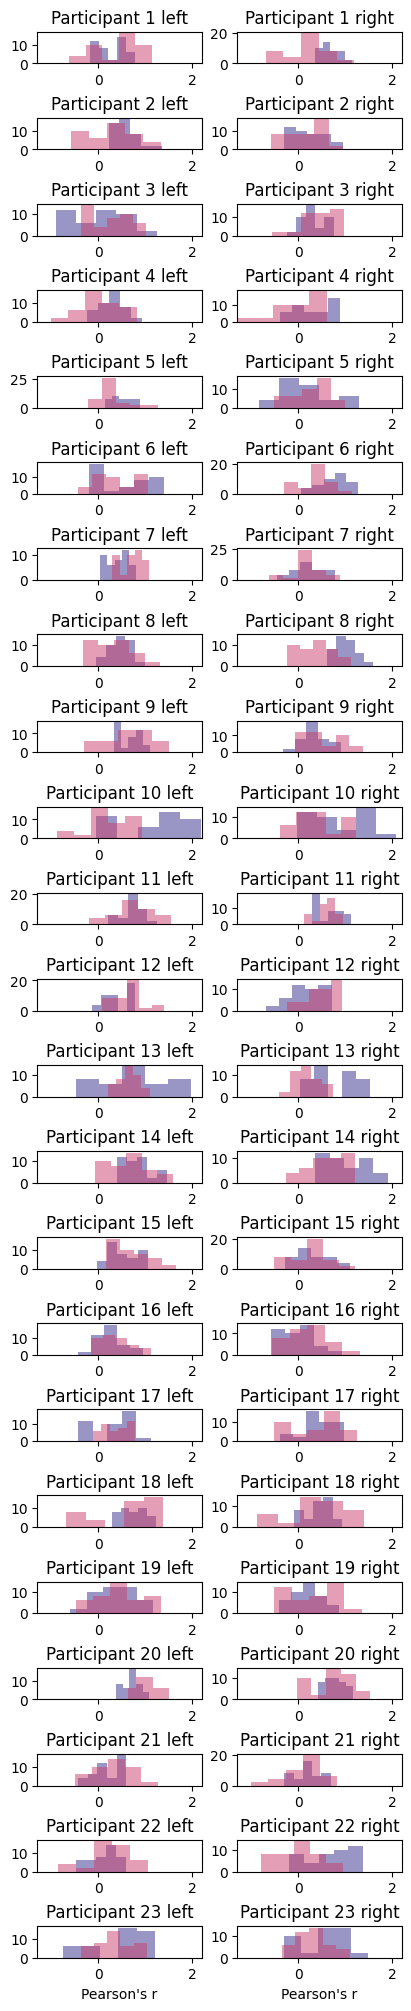

In [31]:
fig, axes = plt.subplots(nParticipants, 2, constrained_layout=True, figsize=(4,20))
colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink

for subj in np.arange(nParticipants):
  for h,hem in enumerate(['left', 'right']):
    for r,roi in enumerate(['posterior', 'anterior']):
      axes[subj,h].hist(neural_ZNSMs[subj][hem][roi][offmask].flatten(), bins=5, alpha=0.5, color=colors[r])
      axes[subj,h].set_xlim([-1.3, 2.2])
      axes[subj, h].set_title(f'Participant {subj + 1} {hem}')
axes[subj,0].set_xlabel('Pearson\'s r')
axes[subj,1].set_xlabel('Pearson\'s r')

# Model-based analyses

## Define the adjacency matrix and the SR

In [32]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])
T = A / A.sum(axis=1, keepdims=True)

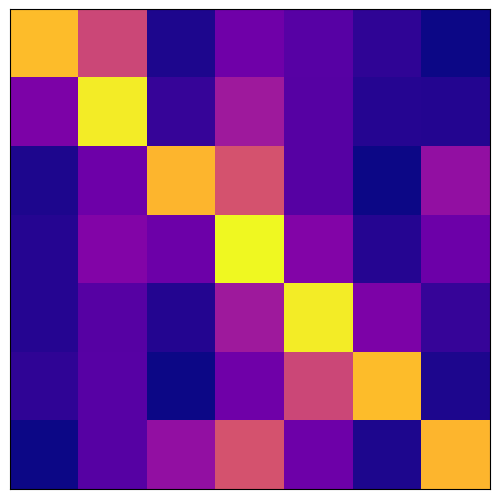

In [33]:
items_idx = [i-1 for i in items]
SR = computeSR(T,0.85) #Only as an illustration for plotting
SR7 =  SR[np.ix_(items_idx, items_idx)] #Select the subset of 7 objects seen on Day 2
fig,ax = plt.subplots()
img = ax.imshow(SR7, cmap='plasma', aspect='equal')

# Add a colorbar to show the scale
#fig.colorbar(img, label='SR')
ax.set_yticks([])
ax.set_xticks([])

# Remove padding around the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.tight_layout(pad=0)


## Fit gamma to RSAs
The model now uses MSE as loss function. The form of the model is Y* = beta0 + beta1*SR(i,j), where SR is parametrized by $\gamma$.

In [34]:
def zscore_matrix(M):
    """Z-score off-diagonal elements of a symmetric matrix."""
    mask = ~np.eye(M.shape[0], dtype=bool)
    vals = M[mask]
    M_z = (M - vals.mean()) / vals.std(ddof=1)
    return M_z

In [35]:
from scipy.special import expit # Ensure this is imported for gamma calculation

def full_objective(theta,
                   neural_ZNSM,  # CHANGE: Renamed argument for clarity (Z-transformed Neural Similarity Matrix)
                   A,
                   model="SR",
                   normalize=normalizeSR,
                   scaling=True):

    beta1 = theta[1]
    beta2 = np.exp(theta[2])  # CHANGE: Removed the negative sign (-np.exp) to enforce beta2 to be POSITIVE (a)


    if model=="SR":
      gamma = expit(theta[0])
      T = A / A.sum(axis=1, keepdims=True)
      SR = computeSR(T, gamma)
      # NOTE: The SR is a measure of similarity, and neural_ZNSM is a measure of
      # similarity (Fisher Z-transformed Pearson r). Thus, beta2 should be positive.

      if scaling:
        SR = zscore_matrix(SR)  # Normalize before subsetting

      # Subset the matrix
      x = SR[np.ix_(items_idx, items_idx)]

    elif model=="DK":
      alpha = np.exp(theta[0])
      K = computeDK(A, alpha)
      if scaling:
        K = zscore_matrix(K)  # Normalize before subsetting
      x = K[np.ix_(items_idx, items_idx)]

    #x = (x+x.T)/2 # Make the x (either DK or SR) symmetric
    #x = 1-squareform(pdist(x, metric='euclidean')) # Replace euclidean with cosine or correlation
    mask = ~np.eye(len(items_idx), dtype=bool)
    X = beta1 + beta2*x[mask].flatten()
    Y = neural_ZNSM[mask].flatten() # Use Fisher Z-transformed matrix (neural_ZNSM)

    D = (Y-X)**2
    mse = np.mean(D)
    #mse = 1 - pearsonr(x,y)[0]
    return mse

### DK

In [36]:
# Model fitting
# This cell fit the DK model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-10, 10), (-100, 100), (-100, 100)] #alpha is from 0 to 100, then beta1 and beta2 are -100, 100

res = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "DK", normalizeSR, True),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]

In [37]:
# I get alpha from the list of dictionaries
alphas = [
    {
        h: {
            roi: res[h][roi].x[0]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

In [38]:
save_dir = "/content/drive/MyDrive/model_fitting"
os.makedirs(save_dir, exist_ok=True)

```
import os
import pickle
import pandas as pd
from datetime import datetime
import json

# ---- Collect model results ----
results_DK = []

for p, subj_res in enumerate(res):  # list over participants
    for hemi in subj_res:
        for roi in subj_res[hemi]:
            fit = subj_res[hemi][roi]
            results_DK.append({
                "participant": p + 1,
                "hemi": hemi,
                "roi": roi,
                "alpha": fit.x[0],
                "beta1": fit.x[1],
                "beta2": np.exp(fit.x[2]),
                "loss": fit.fun
            })

# ---- Save to CSV ----
df_DK = pd.DataFrame(results_DK)
csv_path = os.path.join(save_dir, "results_DK_fits2.csv")
df_DK.to_csv(csv_path, index=False)

# ---- Save Python dict version (full) ----
pkl_path = os.path.join(save_dir, "results_DK_fits2.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump(res, f)

# ---- Metadata ----
metadata = {
    "model": "Diffusion Kernel",
    "nParticipants": len(res),
    "fit_date": datetime.now().isoformat(),
    "bounds": bounds,
    "initial_params": x0,
    "loss_type": "mean squared error"
}
json_path = os.path.join(save_dir, "results_DK_metadata2.json")
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ All results saved to: {save_dir}")
```



In [63]:
SS_tot = {}
n_pairs = {}

for subj_i, subj in enumerate(neural_ZNSMs):
    SS_tot[subj_i] = {}
    n_pairs[subj_i] = {}
    for h in subj:
        SS_tot[subj_i][h] = {}
        n_pairs[subj_i][h] = {}
        for roi in subj[h]:
            DSM = subj[h][roi]
            mask = ~np.eye(DSM.shape[0], dtype=bool)
            y = DSM[mask].flatten()
            SS_tot[subj_i][h][roi] = np.sum((y - y.mean())**2)
            n_pairs[subj_i][h][roi] = y.size

In [64]:
R2_DK = []
for subj_i, subj in enumerate(res):
    subj_r2 = {}
    for h in subj:
        subj_r2[h] = {}
        for roi in subj[h]:
            mse = subj[h][roi].fun
            ss = SS_tot[subj_i][h][roi]
            n = n_pairs[subj_i][h][roi]
            r2 = 1 - (n * mse) / ss
            subj_r2[h][roi] = r2
    R2_DK.append(subj_r2)

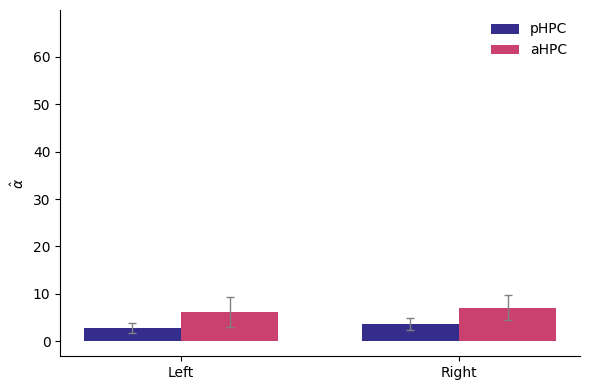

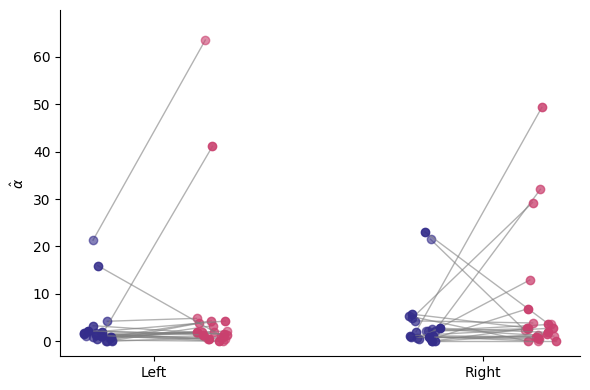

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import t

# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
# data structure: alphas[p][hemi][roi]
# with hemi in {'left', 'right'} and roi in {'posterior', 'anterior'}

nParticipants = len(alphas)
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[np.exp(alphas[p]['left']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['left']['anterior'])  for p in range(nParticipants)]],
    [[np.exp(alphas[p]['right']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['right']['anterior'])  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
# Dynamic y-axis limit with some padding at the bottom and top
ymax = np.max(data)
ax.set_ylim(-0.05 * ymax, ymax + 0.1 * ymax)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (color-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = np.exp(alphas[p][h]['posterior'])
        y_ant  = np.exp(alphas[p][h]['anterior'])

        # Connect posterior/anterior within participant
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Individual points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
# Dynamic y-axis limit with some padding at the bottom and top
ymax = np.max(data)
ax.set_ylim(-0.05 * ymax, ymax + 0.1 * ymax)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

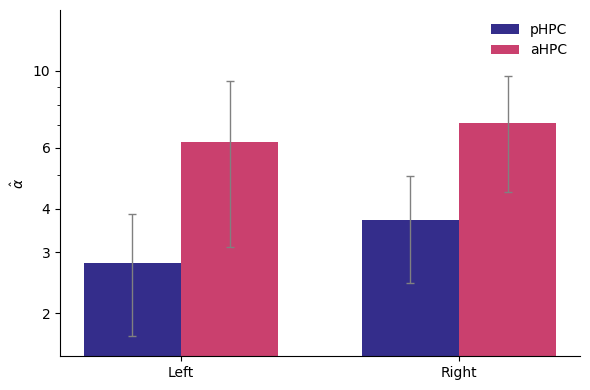

/tmp/ipython-input-2011360902.py:102: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(-0.05 * ymax, ymax + 0.3 * ymax)


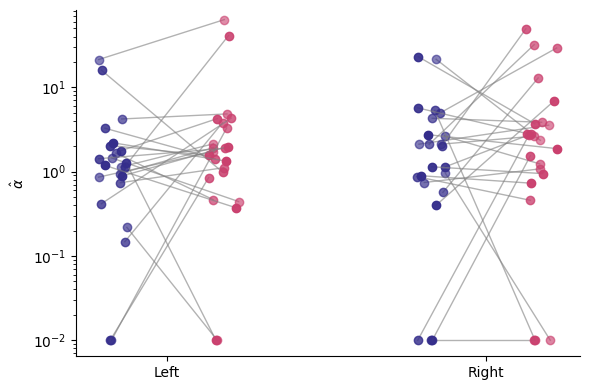

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import t

# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
# data structure: alphas[p][hemi][roi]
# with hemi in {'left', 'right'} and roi in {'posterior', 'anterior'}

nParticipants = len(alphas)
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[np.exp(alphas[p]['left']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['left']['anterior'])  for p in range(nParticipants)]],
    [[np.exp(alphas[p]['right']['posterior']) for p in range(nParticipants)],
     [np.exp(alphas[p]['right']['anterior'])  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

# Formatting
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')

# --- Custom tick labels ---
custom_ticks = [2, 3, 4, 6, 10]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(t) for t in custom_ticks])

# --- Axis limits and legend ---
ax.set_ylim(1.5, 15)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (color-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = np.clip(np.exp(alphas[p][h]['posterior']),0.01,100)
        y_ant  = np.clip(np.exp(alphas[p][h]['anterior']),0.01,100)

        # Connect posterior/anterior within participant
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Individual points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

# Formatting
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
# Dynamic y-axis limit with some padding at the bottom and top
ymax = np.max(data)
ax.set_ylim(-0.05 * ymax, ymax + 0.3 * ymax)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

/tmp/ipython-input-4191820703.py:27: RuntimeWarning: invalid value encountered in log
  log_data = np.log(data + eps)


ValueError: Axis limits cannot be NaN or Inf

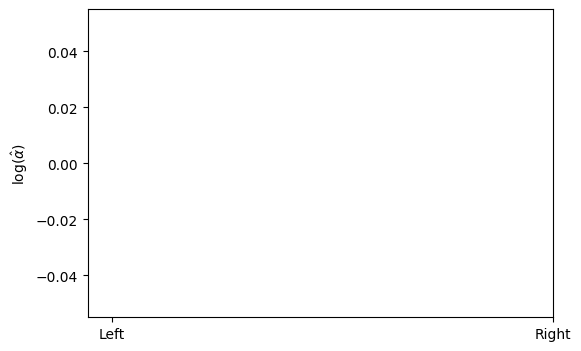

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import t

# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
# data structure: alphas[p][hemi][roi]
# with hemi in {'left', 'right'} and roi in {'posterior', 'anterior'}

nParticipants = len(alphas)
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35
eps = 1e-6  # small constant to avoid log(0)

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[alphas[p]['left']['posterior'] for p in range(nParticipants)],
     [alphas[p]['left']['anterior']  for p in range(nParticipants)]],
    [[alphas[p]['right']['posterior'] for p in range(nParticipants)],
     [alphas[p]['right']['anterior']  for p in range(nParticipants)]]
])

# Apply log-transform (for analysis & visualization)
log_data = np.log(data + eps)

# Compute mean and 95% CI on the log scale
means = np.mean(log_data, axis=2)
sems = np.std(log_data, axis=2, ddof=1) / np.sqrt(nParticipants)
t_val = t.ppf(0.975, df=nParticipants - 1)
cis95 = sems * t_val

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey 95% CIs (log scale)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=cis95[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=cis95[:, 1], error_kw=error_kw)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\log(\hat{\alpha})$')

# Dynamic y-axis limit with padding
ymin, ymax = np.min(log_data), np.max(log_data)
ax.set_ylim(ymin - 0.1*(ymax - ymin), ymax + 0.1*(ymax - ymin))

ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data on log scale
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = np.log(alphas[p][h]['posterior'] + eps)
        y_ant  = np.log(alphas[p][h]['anterior'] + eps)

        # Connect posterior/anterior within participant
        ax.plot([x_post, x_ant], [y_post, y_ant],
                '-', color='grey', alpha=0.6, linewidth=1)

        # Individual points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\log(\hat{\alpha})$')

# Dynamic y-axis limits
ymin, ymax = np.min(log_data), np.max(log_data)
ax.set_ylim(ymin - 0.1*(ymax - ymin), ymax + 0.1*(ymax - ymin))
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [67]:
from scipy.stats import ttest_rel, t as t_dist

df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [np.exp(alphas[p]['left']['posterior']) for p in range(nParticipants)], #We added 1e-12 bc. otherwise it returns NaNs when trying to do log of 0
    [np.exp(alphas[p]['left']['anterior']) for p in range(nParticipants)]
)
print(f"DK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [np.exp(alphas[p]['right']['posterior']) for p in range(nParticipants)],
    [np.exp(alphas[p]['right']['anterior']) for p in range(nParticipants)]
)
print(f"DK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

DK Left hemisphere:  t(22) = -1.329,  p = 0.198
DK Right hemisphere: t(22) = -1.134,  p = 0.269


In [68]:
# note to self: look at the alpha values
alphas

[{'left': {'posterior': np.float64(3.060464174005382),
   'anterior': np.float64(4.151694914346249)},
  'right': {'posterior': np.float64(3.067883487759626),
   'anterior': np.float64(0.8557269291372167)}},
 {'left': {'posterior': np.float64(0.12332777733614697),
   'anterior': np.float64(0.759751764494402)},
  'right': {'posterior': np.float64(0.7493011934059436),
   'anterior': np.float64(1.2690644133078235)}},
 {'left': {'posterior': np.float64(-0.15060987677336873),
   'anterior': np.float64(0.5457074575142088)},
  'right': {'posterior': np.float64(-0.04152219659893599),
   'anterior': np.float64(-8.828804528115723)}},
 {'left': {'posterior': np.float64(0.37531470177871057),
   'anterior': np.float64(-0.8172846517509743)},
  'right': {'posterior': np.float64(0.7477570438012399),
   'anterior': np.float64(0.9689945490342619)}},
 {'left': {'posterior': np.float64(-1.521853075836328),
   'anterior': np.float64(-6.442770723573854)},
  'right': {'posterior': np.float64(-0.29724872965631

**R2**

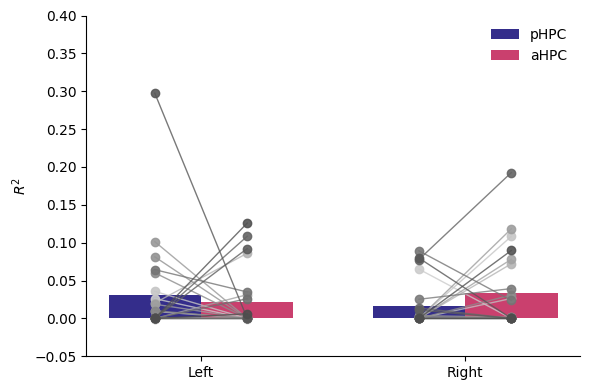

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Compute total sum of squares (SS_tot) for each DSM
# ------------------------------------------------------
SS_tot = []
for subj in neural_ZNSMs:  # subj is a dict: subj[h][roi] -> DSM (square)
    ss_subj = {}
    for h, rois in subj.items():
        ss_subj[h] = {}
        for roi, DSM in rois.items():
            DSM = np.asarray(DSM)
            offmask = ~np.eye(DSM.shape[0], dtype=bool)
            y = DSM[offmask].ravel()
            ss_subj[h][roi] = {
                "SS_tot": float(((y - y.mean()) ** 2).sum()),
                "n": y.size
            }
    SS_tot.append(ss_subj)

# ------------------------------------------------------
# 2) Extract MSE from model fitting results
# ------------------------------------------------------
MSE = [
    {
        h: {
            roi: res[h][roi].fun
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

# ------------------------------------------------------
# 3) Compute R² for each subject, hemisphere, and ROI
# ------------------------------------------------------
R2 = []
for ss_subj, mse_subj in zip(SS_tot, MSE):
    r2_subj = {}
    for h, rois in mse_subj.items():
        r2_subj[h] = {}
        for roi, mse in rois.items():
            ss = ss_subj[h][roi]["SS_tot"]
            n = ss_subj[h][roi]["n"]
            r2_subj[h][roi] = np.nan if ss == 0 else 1.0 - (n * mse) / ss
            # optional: clip tiny negatives -> r2_subj[h][roi] = max(0.0, r2_subj[h][roi])
    R2.append(r2_subj)

# ------------------------------------------------------
# 4) Build array: shape (2 hemispheres, 2 ROIs, nParticipants)
# ------------------------------------------------------
hemis = ['left', 'right']
rois = ['posterior', 'anterior']

data_R2 = np.array([
    [
        [R2[p][hemis[h]][rois[r]] for p in range(nParticipants)]
        for r in range(2)
    ]
    for h in range(2)
])

# Compute mean R² across participants
means = np.nanmean(data_R2, axis=2)

# ------------------------------------------------------
# 5) Plot group means + participant-level data
# ------------------------------------------------------
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink

bars_post = ax.bar(
    x - width / 2, means[:, 0], width,
    label='pHPC', color=colors[0]
)
bars_ant = ax.bar(
    x + width / 2, means[:, 1], width,
    label='aHPC', color=colors[1]
)

# Participant-level lines and dots
greys = [str(0.3 + 0.5 * i / max(1, (nParticipants - 1))) for i in range(nParticipants)]
greys = list(reversed(greys))

for p in range(nParticipants):
    color = greys[p]
    for i, h in enumerate(hemis):
        x_post = x[i] - width / 2
        x_ant = x[i] + width / 2
        y_post = R2[p][h]['posterior']
        y_ant = R2[p][h]['anterior']

        # Plot only if finite
        if np.isfinite(y_post) and np.isfinite(y_ant):
            ax.plot([x_post, x_ant], [y_post, y_ant],
                    '-', color=color, alpha=0.8, linewidth=1)
        if np.isfinite(y_post):
            ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        if np.isfinite(y_ant):
            ax.plot(x_ant, y_ant, 'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05, 0.4)  # adjust if R² < 0
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [44]:
from scipy.stats import ttest_1samp

In [45]:
for h in ['left', 'right']:
  for roi in ['posterior', 'anterior']:
    print(h, ' ', roi, ' ', ttest_1samp([r[h][roi] for r in R2], 0))

left   posterior   TtestResult(statistic=np.float64(2.3251017629271593), pvalue=np.float64(0.029686932187223215), df=np.int64(22))
left   anterior   TtestResult(statistic=np.float64(2.6637544877886246), pvalue=np.float64(0.014184218231094158), df=np.int64(22))
right   posterior   TtestResult(statistic=np.float64(2.57042961687282), pvalue=np.float64(0.017449729976194542), df=np.int64(22))
right   anterior   TtestResult(statistic=np.float64(3.140557835216985), pvalue=np.float64(0.004751732474712836), df=np.int64(22))


Number of data points in Right Posterior plot: 23
Number of data points in Right Anterior plot: 23


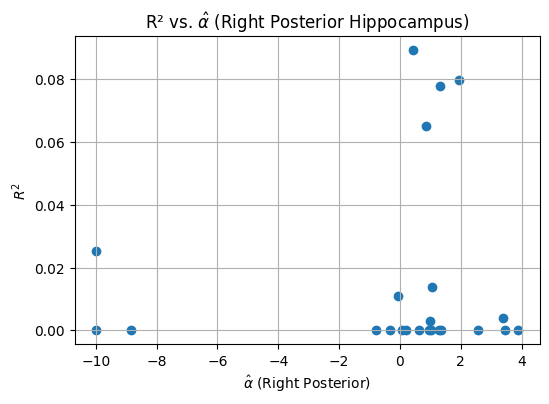

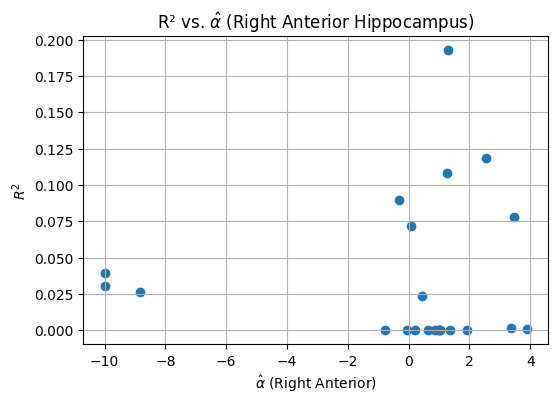

Correlation between R² and alpha in Right Posterior: r = 0.078, p = 0.724
Correlation between R² and alpha in Right Anterior: r = 0.040, p = 0.855


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract R2 and alpha values for the right hemisphere
r2_right_posterior = [R2[p]['right']['posterior'] for p in range(nParticipants)]
r2_right_anterior = [R2[p]['right']['anterior'] for p in range(nParticipants)]

alphas_right_posterior = [alphas[p]['right']['posterior'] for p in range(nParticipants)]
alphas_right_anterior = [alphas[p]['right']['anterior'] for p in range(nParticipants)]

# Remove NaN values for plotting and correlation
valid_posterior_indices = np.isfinite(r2_right_posterior) & np.isfinite(alphas_right_posterior)
valid_anterior_indices = np.isfinite(r2_right_anterior) & np.isfinite(alphas_right_anterior)

r2_right_posterior_valid = np.array(r2_right_posterior)[valid_posterior_indices]
alphas_right_posterior_valid = np.array(alphas_right_anterior)[valid_posterior_indices] # Changed to anterior to match the plot

r2_right_anterior_valid = np.array(r2_right_anterior)[valid_anterior_indices]
alphas_right_anterior_valid = np.array(alphas_right_anterior)[valid_anterior_indices]

# Print the number of data points used in each plot
print(f"Number of data points in Right Posterior plot: {len(r2_right_posterior_valid)}")
print(f"Number of data points in Right Anterior plot: {len(r2_right_anterior_valid)}")

# Plot for Right Posterior
plt.figure(figsize=(6, 4))
plt.scatter(alphas_right_posterior_valid, r2_right_posterior_valid)
plt.xlabel(r'$\hat{\alpha}$ (Right Posterior)')
plt.ylabel(r'$R^2$')
plt.title(r'R² vs. $\hat{\alpha}$ (Right Posterior Hippocampus)')
plt.grid(True)
plt.show()

# Plot for Right Anterior
plt.figure(figsize=(6, 4))
plt.scatter(alphas_right_anterior_valid, r2_right_anterior_valid)
plt.xlabel(r'$\hat{\alpha}$ (Right Anterior)')
plt.ylabel(r'$R^2$')
plt.title(r'R² vs. $\hat{\alpha}$ (Right Anterior Hippocampus)')
plt.grid(True)
plt.show()

# Calculate and print correlation for Right Posterior
r_posterior, p_posterior = pearsonr(alphas_right_posterior_valid, r2_right_posterior_valid)
print(f"Correlation between R² and alpha in Right Posterior: r = {r_posterior:.3f}, p = {p_posterior:.3f}")

# Calculate and print correlation for Right Anterior
r_anterior, p_anterior = pearsonr(alphas_right_anterior_valid, r2_right_anterior_valid)
print(f"Correlation between R² and alpha in Right Anterior: r = {r_anterior:.3f}, p = {p_anterior:.3f}")

**Bayesian Information Criterion (BIC)**

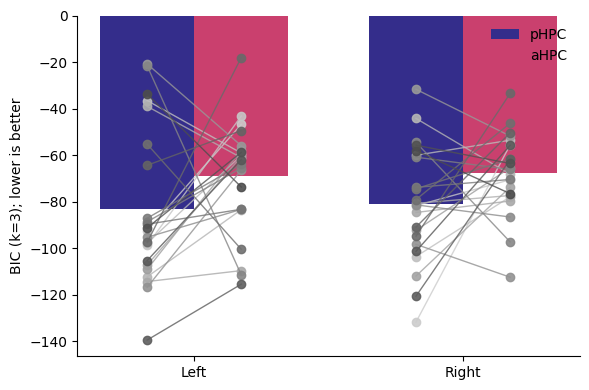

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Compute BIC from MSE (Gaussian errors; constants omitted)
# ------------------------------------------------------
# Formula: BIC = n * ln(MSE) + k * ln(n)
k = 3
BIC = []

for ss_subj, mse_subj in zip(SS_tot, MSE):
    bic_subj = {}
    for h, rois in mse_subj.items():
        bic_subj[h] = {}
        for roi, mse in rois.items():
            n = ss_subj[h][roi]["n"]
            if not np.isfinite(mse) or mse <= 0 or n <= 0:
                bic = np.nan
            else:
                bic = n * np.log(mse) + k * np.log(n)
            bic_subj[h][roi] = bic
    BIC.append(bic_subj)

# ------------------------------------------------------
# 2) Build array: shape (2 hemispheres, 2 ROIs, nParticipants)
# ------------------------------------------------------
hemis = ['left', 'right']
rois = ['posterior', 'anterior']

data_BIC = np.array([
    [
        [BIC[p][hemis[h]][rois[r]] for p in range(nParticipants)]
        for r in range(2)
    ]
    for h in range(2)
])

# Compute means across participants -> shape (2, 2)
means = np.nanmean(data_BIC, axis=2)

# ------------------------------------------------------
# 3) Plot: grouped bars + participant lines and dots
# ------------------------------------------------------
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink

bars_post = ax.bar(
    x - width / 2, means[:, 0], width,
    label='pHPC', color=colors[0]
)
bars_ant = ax.bar(
    x + width / 2, means[:, 1], width,
    label='aHPC', color=colors[1]
)

# Participant-level lines and dots (skip NaNs)
greys = [str(0.3 + 0.5 * i / max(1, (nParticipants - 1))) for i in range(nParticipants)]
greys = list(reversed(greys))

for p in range(nParticipants):
    color = greys[p]
    for i, h in enumerate(hemis):
        x_post = x[i] - width / 2
        x_ant = x[i] + width / 2
        y_post = BIC[p][h]['posterior']
        y_ant = BIC[p][h]['anterior']
        if np.isfinite(y_post) and np.isfinite(y_ant):
            ax.plot([x_post, x_ant], [y_post, y_ant],
                    '-', color=color, alpha=0.8, linewidth=1)
        if np.isfinite(y_post):
            ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        if np.isfinite(y_ant):
            ax.plot(x_ant, y_ant, 'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('BIC (k=3); lower is better')
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

Number of data points in Right Posterior (Alpha vs. BIC) plot: 23
Number of data points in Right Anterior (Alpha vs. BIC) plot: 23


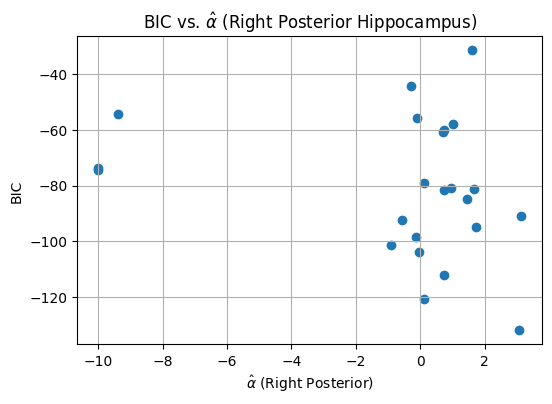

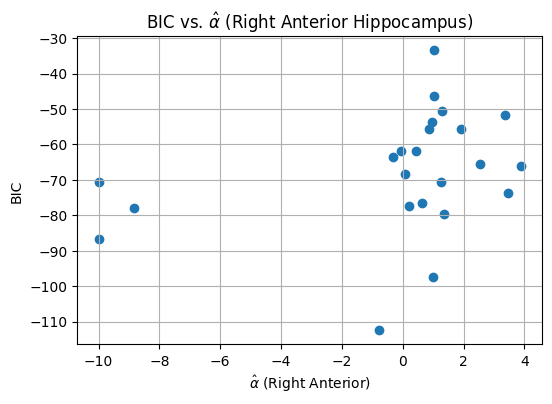

Correlation between BIC and alpha in Right Posterior: r = -0.237, p = 0.276
Correlation between BIC and alpha in Right Anterior: r = 0.309, p = 0.151


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract alpha and BIC values for the right hemisphere
alphas_right_posterior = [alphas[p]['right']['posterior'] for p in range(nParticipants)]
alphas_right_anterior = [alphas[p]['right']['anterior'] for p in range(nParticipants)]

bic_right_posterior = [BIC[p]['right']['posterior'] for p in range(nParticipants)]
bic_right_anterior = [BIC[p]['right']['anterior'] for p in range(nParticipants)]

# Remove NaN values for plotting and correlation
valid_posterior_indices_bic = np.isfinite(alphas_right_posterior) & np.isfinite(bic_right_posterior)
valid_anterior_indices_bic = np.isfinite(alphas_right_anterior) & np.isfinite(bic_right_anterior)

alphas_right_posterior_valid_bic = np.array(alphas_right_posterior)[valid_posterior_indices_bic]
bic_right_posterior_valid = np.array(bic_right_posterior)[valid_posterior_indices_bic]

alphas_right_anterior_valid_bic = np.array(alphas_right_anterior)[valid_anterior_indices_bic]
bic_right_anterior_valid = np.array(bic_right_anterior)[valid_anterior_indices_bic]

# Print the number of data points used in each plot
print(f"Number of data points in Right Posterior (Alpha vs. BIC) plot: {len(alphas_right_posterior_valid_bic)}")
print(f"Number of data points in Right Anterior (Alpha vs. BIC) plot: {len(alphas_right_anterior_valid_bic)}")


# Plot for Right Posterior (Alpha vs. BIC)
plt.figure(figsize=(6, 4))
plt.scatter(alphas_right_posterior_valid_bic, bic_right_posterior_valid)
plt.xlabel(r'$\hat{\alpha}$ (Right Posterior)')
plt.ylabel('BIC')
plt.title(r'BIC vs. $\hat{\alpha}$ (Right Posterior Hippocampus)')
plt.grid(True)
plt.show()

# Plot for Right Anterior (Alpha vs. BIC)
plt.figure(figsize=(6, 4))
plt.scatter(alphas_right_anterior_valid_bic, bic_right_anterior_valid)
plt.xlabel(r'$\hat{\alpha}$ (Right Anterior)')
plt.ylabel('BIC')
plt.title(r'BIC vs. $\hat{\alpha}$ (Right Anterior Hippocampus)')
plt.grid(True)
plt.show()

# Calculate and print correlation for Right Posterior (Alpha vs. BIC)
r_posterior_bic, p_posterior_bic = pearsonr(alphas_right_posterior_valid_bic, bic_right_posterior_valid)
print(f"Correlation between BIC and alpha in Right Posterior: r = {r_posterior_bic:.3f}, p = {p_posterior_bic:.3f}")

# Calculate and print correlation for Right Anterior (Alpha vs. BIC)
r_anterior_bic, p_anterior_bic = pearsonr(alphas_right_anterior_valid_bic, bic_right_anterior_valid)
print(f"Correlation between BIC and alpha in Right Anterior: r = {r_anterior_bic:.3f}, p = {p_anterior_bic:.3f}")

### SR

In [71]:
# Model fitting
# This cell fit the SR model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-5, 5), (-100, 100), (-100, ub)]

res_SR = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "SR", normalizeSR),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_ZNSMs
]

In [72]:
# I get gamma from the list of dictionaries
gammas = [
    {
        h: {
            roi: expit(res[h][roi].x[0])
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

In [73]:
R2_SR = []
for subj_i, subj in enumerate(res_SR):  # or 'res' if you didn’t rename
    subj_r2 = {}
    for h in subj:
        subj_r2[h] = {}
        for roi in subj[h]:
            mse = subj[h][roi].fun        # model MSE
            ss = SS_tot[subj_i][h][roi]   # total variance of neural DSM
            n = n_pairs[subj_i][h][roi]   # number of off-diagonal pairs
            r2 = 1 - (n * mse) / ss
            subj_r2[h][roi] = r2
    R2_SR.append(subj_r2)

NameError: name 'res_SR' is not defined

```
import os
import pickle
import pandas as pd
from datetime import datetime
import json

# ---- Define save directory ----
save_dir = "/content/drive/MyDrive/model_fitting"
os.makedirs(save_dir, exist_ok=True)

# ---- Collect model results ----
results_SR = []

for p, subj_res in enumerate(res):  # list over participants
    for hemi in subj_res:
        for roi in subj_res[hemi]:
            fit = subj_res[hemi][roi]
            results_SR.append({
                "participant": p + 1,
                "hemi": hemi,
                "roi": roi,
                "gamma": expit(fit.x[0]),  # convert logit gamma to bounded [0,1]
                "beta1": fit.x[1],
                "beta2": np.exp(fit.x[2]),  # back-transform from log space
                "loss": fit.fun
            })

# ---- Save to CSV ----
df_SR = pd.DataFrame(results_SR)
csv_path = os.path.join(save_dir, "results_SR_fits.csv")
df_SR.to_csv(csv_path, index=False)

# ---- Save Python dict version (full) ----
pkl_path = os.path.join(save_dir, "results_SR_fits.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump(res, f)

# ---- Metadata ----
metadata = {
    "model": "Successor Representation",
    "nParticipants": len(res),
    "fit_date": datetime.now().isoformat(),
    "bounds": bounds,
    "initial_params": x0,
    "loss_type": "mean squared error",
}
json_path = os.path.join(save_dir, "results_SR_metadata.json")
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ All SR results saved to: {save_dir}")
```



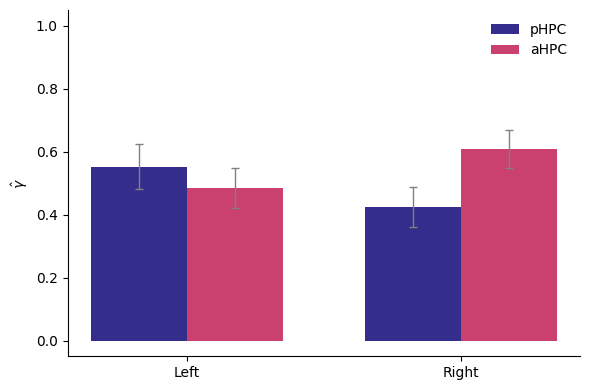

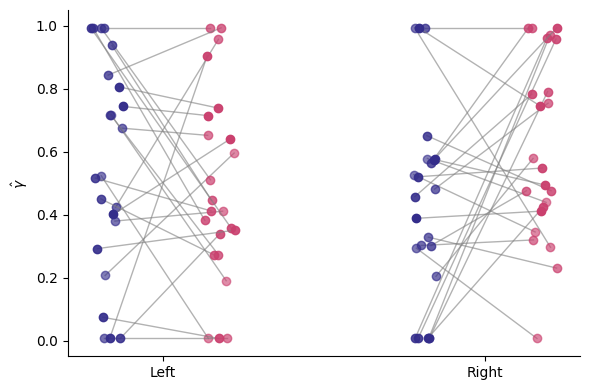

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# ---------------------------------------------------------------------
# 1. Prepare data
# ---------------------------------------------------------------------
nParticipants = len(gammas)
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

# Convert to array (shape: [hemisphere, roi, participant])
data = np.array([
    [[gammas[p]['left']['posterior'] for p in range(nParticipants)],
     [gammas[p]['left']['anterior']  for p in range(nParticipants)]],
    [[gammas[p]['right']['posterior'] for p in range(nParticipants)],
     [gammas[p]['right']['anterior']  for p in range(nParticipants)]]
])

# Compute mean and SEM
means = np.mean(data, axis=2)
sems = np.std(data, axis=2, ddof=1) / np.sqrt(nParticipants)

# ---------------------------------------------------------------------
# 2. Plot 1: Group means with grey SEM error bars and legend
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink
error_kw = dict(lw=1, capsize=3, capthick=1, ecolor='grey')

bars_post = ax.bar(x - width/2, means[:, 0], width,
                   label='pHPC', color=colors[0],
                   yerr=sems[:, 0], error_kw=error_kw)

bars_ant = ax.bar(x + width/2, means[:, 1], width,
                  label='aHPC', color=colors[1],
                  yerr=sems[:, 1], error_kw=error_kw)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')
ax.set_ylim(-0.05, 1.05)
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Plot 2: Individual participant data (colour-coded + connecting lines)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

n = nParticipants
blue_rgba = np.array(to_rgba('#342d8bff'))
pink_rgba = np.array(to_rgba('#ca406eff'))

blue_shades = [blue_rgba.copy() for _ in range(n)]
pink_shades = [pink_rgba.copy() for _ in range(n)]
for i in range(n):
    blue_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))  # varying alpha
    pink_shades[i][-1] = 0.6 + 0.4 * (i / (n - 1))

jitter = 0.05  # slight horizontal jitter

for p in range(nParticipants):
    for i, h in enumerate(['left', 'right']):
        x_post = x[i] - width/2 + np.random.uniform(-jitter, jitter)
        x_ant  = x[i] + width/2 + np.random.uniform(-jitter, jitter)
        y_post = gammas[p][h]['posterior']
        y_ant  = gammas[p][h]['anterior']

        # Connect posterior and anterior points
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color='grey', alpha=0.6, linewidth=1)

        # Plot points
        ax.plot(x_post, y_post, 'o', color=blue_shades[p], markersize=6)
        ax.plot(x_ant,  y_ant,  'o', color=pink_shades[p], markersize=6)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')
ax.set_ylim(-0.05, 1.05)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [52]:
print("Number of participants fitted:", len(res))

Number of participants fitted: 23


In [53]:
print("data.shape =", data.shape)


data.shape = (2, 2, 23)


In [54]:
# I get betas from the list of dictionaries
betas = [
    {
        h: {
            roi: res[h][roi].x[2]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

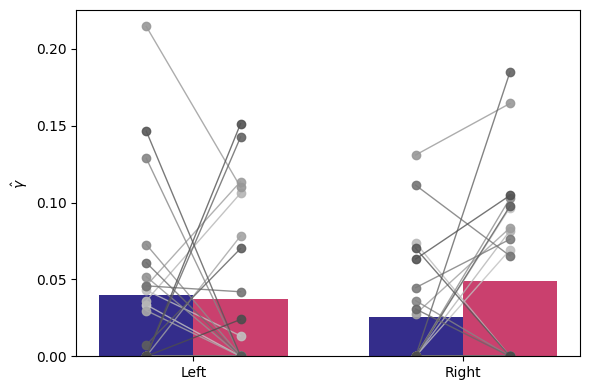

In [55]:
# Transform into array to compute the mean
# Data is (2x2xnParticipants). The first dimension is the hemisphere, the second
# is the ROI (posterior and anterior).
data = np.array([
     [[np.exp(betas[p]['left']['posterior']) for p in range(nParticipants)],  # Left, Posterior
      [np.exp(betas[p]['left']['anterior']) for p in range(nParticipants)]],  # Left, Anterior
     [[np.exp(betas[p]['right']['posterior']) for p in range(nParticipants)], # Right, Posterior
      [np.exp(betas[p]['right']['anterior']) for p in range(nParticipants)]]  # Right, Anterior
])

# Compute means: (2, 2) → (hemisphere, location)
means = np.mean(data, axis=2)

# Setup
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))

# Plot: Posterior bars on left, Anterior bars on right within each hemisphere group
colors = ['#342d8bff', '#ca406eff']  # Posterior = blue, Anterior = orange

bars_post = ax.bar(x - width/2, means[:, 0], width, label='pHPC', color=colors[0])
bars_ant  = ax.bar(x + width/2, means[:, 1], width, label='aHPC',  color=colors[1])

# Plot participant-level lines and dots
jitter = 0

greys = [str(0.3 + 0.5 * i / (nParticipants - 1)) for i in range(nParticipants)]
greys = list(reversed(greys))
participant_labels = participants

for p in range(nParticipants):
    color = greys[p]
    for i,h in enumerate(gammas[p].keys()):
        x_post = x[i] - width/2
        x_ant  = x[i] + width/2
        y_post = np.exp(betas[p][h]['posterior'])
        y_ant  = np.exp(betas[p][h]['anterior'])

        # Line connecting posterior and anterior
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color=color, alpha=0.8, linewidth=1)

        # Dots
        ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        ax.plot(x_ant,  y_ant,  'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')

# Get existing bar legend handles
existing_handles, existing_labels = ax.get_legend_handles_labels()

plt.tight_layout()

plt.show()

In [56]:
# Statistical test
# We use a very simple paired t-test

df = nParticipants - 1

# Left hemisphere
t_stat, p_value = ttest_rel([logit(gammas[p]['left']['posterior']) for p in range(nParticipants)],
                            [logit(gammas[p]['left']['anterior']) for p in range(nParticipants)])

print(f"Left: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

# Right hemisphere
t_stat, p_value = ttest_rel([logit(gammas[p]['right']['posterior']) for p in range(nParticipants)],
                            [logit(gammas[p]['right']['anterior']) for p in range(nParticipants)])

print(f"Right: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

Left: t(22) = 0.726, p = 0.476
Right: t(22) = -1.803, p = 0.085


In [57]:
# Statistical test
# We use a very simple paired t-test

df = nParticipants - 1

# Left hemisphere
t_stat, p_value = ttest_rel([gammas[p]['left']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['left']['anterior'] for p in range(nParticipants)])

print(f"Left: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

# Right hemisphere
t_stat, p_value = ttest_rel([gammas[p]['right']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['right']['anterior'] for p in range(nParticipants)])

print(f"Right: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

Left: t(22) = 0.824, p = 0.419
Right: t(22) = -2.016, p = 0.056


### *R* 2 and BIC

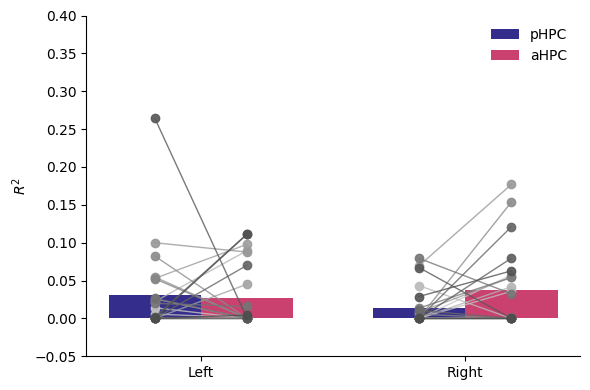

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Compute total sum of squares (SS_tot) for each DSM
# ------------------------------------------------------
SS_tot = []
for subj in neural_ZNSMs:  # subj is a dict: subj[h][roi] -> DSM (square)
    ss_subj = {}
    for h, rois in subj.items():
        ss_subj[h] = {}
        for roi, DSM in rois.items():
            DSM = np.asarray(DSM)
            offmask = ~np.eye(DSM.shape[0], dtype=bool)
            y = DSM[offmask].ravel()
            ss_subj[h][roi] = {
                "SS_tot": float(((y - y.mean()) ** 2).sum()),
                "n": y.size
            }
    SS_tot.append(ss_subj)

# ------------------------------------------------------
# 2) Extract MSE from model fitting results
# ------------------------------------------------------
MSE = [
    {
        h: {
            roi: res[h][roi].fun
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

# ------------------------------------------------------
# 3) Compute R² for each subject, hemisphere, and ROI
# ------------------------------------------------------
R2 = []
for ss_subj, mse_subj in zip(SS_tot, MSE):
    r2_subj = {}
    for h, rois in mse_subj.items():
        r2_subj[h] = {}
        for roi, mse in rois.items():
            ss = ss_subj[h][roi]["SS_tot"]
            n = ss_subj[h][roi]["n"]
            r2_subj[h][roi] = np.nan if ss == 0 else 1.0 - (n * mse) / ss
            # optional: clip tiny negatives -> r2_subj[h][roi] = max(0.0, r2_subj[h][roi])
    R2.append(r2_subj)

# ------------------------------------------------------
# 4) Build array: shape (2 hemispheres, 2 ROIs, nParticipants)
# ------------------------------------------------------
hemis = ['left', 'right']
rois = ['posterior', 'anterior']

data_R2 = np.array([
    [
        [R2[p][hemis[h]][rois[r]] for p in range(nParticipants)]
        for r in range(2)
    ]
    for h in range(2)
])

# Compute mean R² across participants
means = np.nanmean(data_R2, axis=2)

# ------------------------------------------------------
# 5) Plot group means + participant-level data
# ------------------------------------------------------
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink

bars_post = ax.bar(
    x - width / 2, means[:, 0], width,
    label='pHPC', color=colors[0]
)
bars_ant = ax.bar(
    x + width / 2, means[:, 1], width,
    label='aHPC', color=colors[1]
)

# Participant-level lines and dots
greys = [str(0.3 + 0.5 * i / max(1, (nParticipants - 1))) for i in range(nParticipants)]
greys = list(reversed(greys))

for p in range(nParticipants):
    color = greys[p]
    for i, h in enumerate(hemis):
        x_post = x[i] - width / 2
        x_ant = x[i] + width / 2
        y_post = R2[p][h]['posterior']
        y_ant = R2[p][h]['anterior']

        # Plot only if finite
        if np.isfinite(y_post) and np.isfinite(y_ant):
            ax.plot([x_post, x_ant], [y_post, y_ant],
                    '-', color=color, alpha=0.8, linewidth=1)
        if np.isfinite(y_post):
            ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        if np.isfinite(y_ant):
            ax.plot(x_ant, y_ant, 'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05, 0.4)  # adjust if R² < 0
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [59]:
for h in ['left', 'right']:
  for roi in ['posterior', 'anterior']:
    print(h, ' ', roi, ' ', ttest_1samp([r[h][roi] for r in R2], 0))

left   posterior   TtestResult(statistic=np.float64(2.5794086023386567), pvalue=np.float64(0.01710726320184922), df=np.int64(22))
left   anterior   TtestResult(statistic=np.float64(3.1062719599935127), pvalue=np.float64(0.005149045581426434), df=np.int64(22))
right   posterior   TtestResult(statistic=np.float64(2.684297021913329), pvalue=np.float64(0.013547220266910303), df=np.int64(22))
right   anterior   TtestResult(statistic=np.float64(3.4668090979936887), pvalue=np.float64(0.002191718518763388), df=np.int64(22))


Number of data points in Right Posterior plot: 23
Number of data points in Right Anterior plot: 23


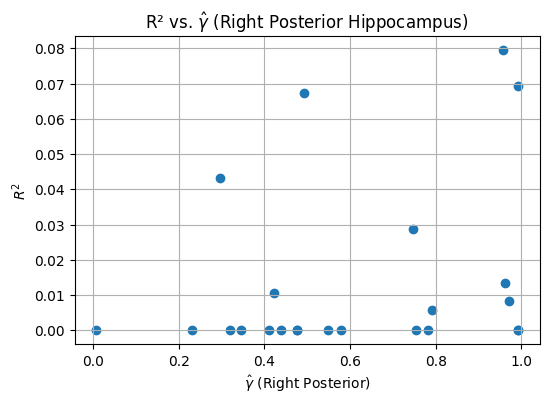

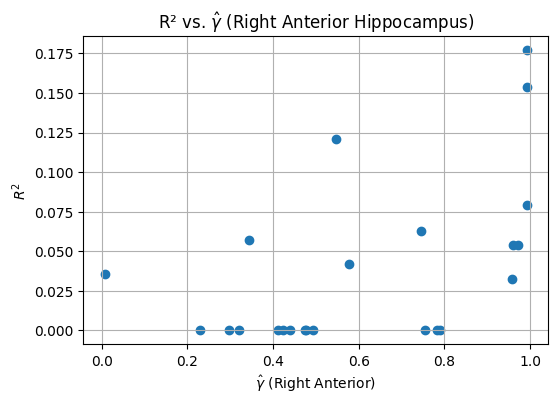

Correlation between R² and gamma in Right Posterior: r = 0.274, p = 0.206
Correlation between R² and gamma in Right Anterior: r = 0.517, p = 0.012


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract R2 and gamma values for the right hemisphere
r2_right_posterior = [R2[p]['right']['posterior'] for p in range(nParticipants)]
r2_right_anterior = [R2[p]['right']['anterior'] for p in range(nParticipants)]

gammas_right_posterior = [gammas[p]['right']['posterior'] for p in range(nParticipants)]
gammas_right_anterior = [gammas[p]['right']['anterior'] for p in range(nParticipants)]

# Remove NaN values for plotting and correlation
valid_posterior_indices = np.isfinite(r2_right_posterior) & np.isfinite(gammas_right_posterior)
valid_anterior_indices = np.isfinite(r2_right_anterior) & np.isfinite(gammas_right_anterior)

r2_right_posterior_valid = np.array(r2_right_posterior)[valid_posterior_indices]
gammas_right_posterior_valid = np.array(gammas_right_anterior)[valid_posterior_indices] # Changed to anterior to match the plot

r2_right_anterior_valid = np.array(r2_right_anterior)[valid_anterior_indices]
gammas_right_anterior_valid = np.array(gammas_right_anterior)[valid_anterior_indices]

# Print the number of data points used in each plot
print(f"Number of data points in Right Posterior plot: {len(r2_right_posterior_valid)}")
print(f"Number of data points in Right Anterior plot: {len(r2_right_anterior_valid)}")

# Plot for Right Posterior
plt.figure(figsize=(6, 4))
plt.scatter(gammas_right_posterior_valid, r2_right_posterior_valid)
plt.xlabel(r'$\hat{\gamma}$ (Right Posterior)')
plt.ylabel(r'$R^2$')
plt.title(r'R² vs. $\hat{\gamma}$ (Right Posterior Hippocampus)')
plt.grid(True)
plt.show()

# Plot for Right Anterior
plt.figure(figsize=(6, 4))
plt.scatter(gammas_right_anterior_valid, r2_right_anterior_valid)
plt.xlabel(r'$\hat{\gamma}$ (Right Anterior)')
plt.ylabel(r'$R^2$')
plt.title(r'R² vs. $\hat{\gamma}$ (Right Anterior Hippocampus)')
plt.grid(True)
plt.show()

# Calculate and print correlation for Right Posterior
r_posterior, p_posterior = pearsonr(gammas_right_posterior_valid, r2_right_posterior_valid)
print(f"Correlation between R² and gamma in Right Posterior: r = {r_posterior:.3f}, p = {p_posterior:.3f}")

# Calculate and print correlation for Right Anterior
r_anterior, p_anterior = pearsonr(gammas_right_anterior_valid, r2_right_anterior_valid)
print(f"Correlation between R² and gamma in Right Anterior: r = {r_anterior:.3f}, p = {p_anterior:.3f}")

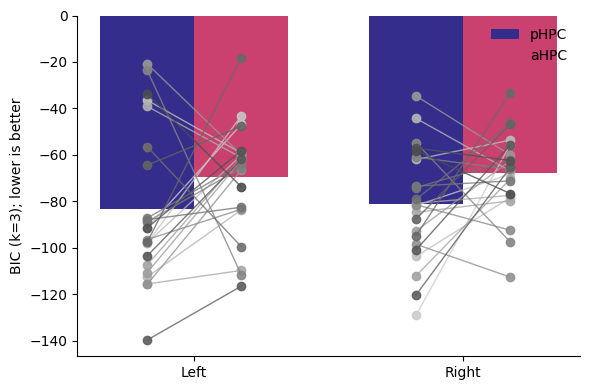

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) Compute BIC from MSE (Gaussian errors; constants omitted)
# ------------------------------------------------------
# Formula: BIC = n * ln(MSE) + k * ln(n)
k = 3
BIC = []

for ss_subj, mse_subj in zip(SS_tot, MSE):
    bic_subj = {}
    for h, rois in mse_subj.items():
        bic_subj[h] = {}
        for roi, mse in rois.items():
            n = ss_subj[h][roi]["n"]
            if not np.isfinite(mse) or mse <= 0 or n <= 0:
                bic = np.nan
            else:
                bic = n * np.log(mse) + k * np.log(n)
            bic_subj[h][roi] = bic
    BIC.append(bic_subj)

# ------------------------------------------------------
# 2) Build array: shape (2 hemispheres, 2 ROIs, nParticipants)
# ------------------------------------------------------
hemis = ['left', 'right']
rois = ['posterior', 'anterior']

data_BIC = np.array([
    [
        [BIC[p][hemis[h]][rois[r]] for p in range(nParticipants)]
        for r in range(2)
    ]
    for h in range(2)
])

# Compute means across participants -> shape (2, 2)
means = np.nanmean(data_BIC, axis=2)

# ------------------------------------------------------
# 3) Plot: grouped bars + participant lines and dots
# ------------------------------------------------------
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#342d8bff', '#ca406eff']  # pHPC = blue, aHPC = pink

bars_post = ax.bar(
    x - width / 2, means[:, 0], width,
    label='pHPC', color=colors[0]
)
bars_ant = ax.bar(
    x + width / 2, means[:, 1], width,
    label='aHPC', color=colors[1]
)

# Participant-level lines and dots (skip NaNs)
greys = [str(0.3 + 0.5 * i / max(1, (nParticipants - 1))) for i in range(nParticipants)]
greys = list(reversed(greys))

for p in range(nParticipants):
    color = greys[p]
    for i, h in enumerate(hemis):
        x_post = x[i] - width / 2
        x_ant = x[i] + width / 2
        y_post = BIC[p][h]['posterior']
        y_ant = BIC[p][h]['anterior']
        if np.isfinite(y_post) and np.isfinite(y_ant):
            ax.plot([x_post, x_ant], [y_post, y_ant],
                    '-', color=color, alpha=0.8, linewidth=1)
        if np.isfinite(y_post):
            ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        if np.isfinite(y_ant):
            ax.plot(x_ant, y_ant, 'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('BIC (k=3); lower is better')
ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

Number of data points in Right Posterior (Gamma vs. BIC) plot: 23
Number of data points in Right Anterior (Gamma vs. BIC) plot: 23


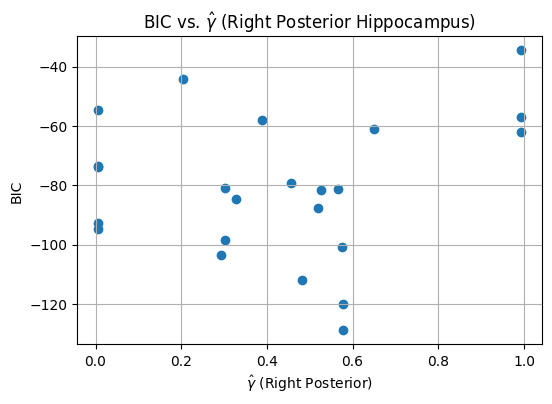

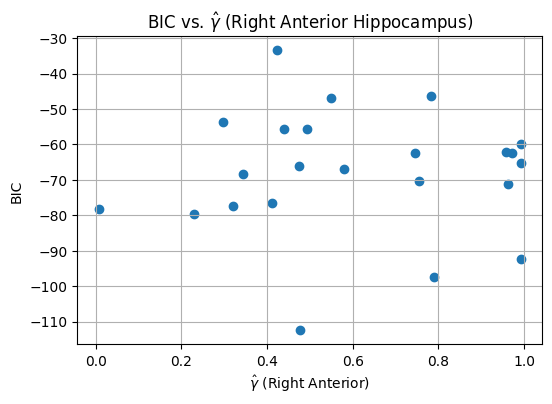

Correlation between BIC and alpha in Right Posterior: r = 0.163, p = 0.456
Correlation between BIC and alpha in Right Anterior: r = 0.015, p = 0.946


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Extract alpha and BIC values for the right hemisphere
gammas_right_posterior = [gammas[p]['right']['posterior'] for p in range(nParticipants)]
gammas_right_anterior = [gammas[p]['right']['anterior'] for p in range(nParticipants)]

bic_right_posterior = [BIC[p]['right']['posterior'] for p in range(nParticipants)]
bic_right_anterior = [BIC[p]['right']['anterior'] for p in range(nParticipants)]

# Remove NaN values for plotting and correlation
valid_posterior_indices_bic = np.isfinite(gammas_right_posterior) & np.isfinite(bic_right_posterior)
valid_anterior_indices_bic = np.isfinite(gammas_right_anterior) & np.isfinite(bic_right_anterior)

gammas_right_posterior_valid_bic = np.array(gammas_right_posterior)[valid_posterior_indices_bic]
bic_right_posterior_valid = np.array(bic_right_posterior)[valid_posterior_indices_bic]

gammas_right_anterior_valid_bic = np.array(gammas_right_anterior)[valid_anterior_indices_bic]
bic_right_anterior_valid = np.array(bic_right_anterior)[valid_anterior_indices_bic]

# Print the number of data points used in each plot
print(f"Number of data points in Right Posterior (Gamma vs. BIC) plot: {len(gammas_right_posterior_valid_bic)}")
print(f"Number of data points in Right Anterior (Gamma vs. BIC) plot: {len(gammas_right_anterior_valid_bic)}")


# Plot for Right Posterior (Gamma vs. BIC)
plt.figure(figsize=(6, 4))
plt.scatter(gammas_right_posterior_valid_bic, bic_right_posterior_valid)
plt.xlabel(r'$\hat{\gamma}$ (Right Posterior)')
plt.ylabel('BIC')
plt.title(r'BIC vs. $\hat{\gamma}$ (Right Posterior Hippocampus)')
plt.grid(True)
plt.show()

# Plot for Right Anterior (Gamma vs. BIC)
plt.figure(figsize=(6, 4))
plt.scatter(gammas_right_anterior_valid_bic, bic_right_anterior_valid)
plt.xlabel(r'$\hat{\gamma}$ (Right Anterior)')
plt.ylabel('BIC')
plt.title(r'BIC vs. $\hat{\gamma}$ (Right Anterior Hippocampus)')
plt.grid(True)
plt.show()

# Calculate and print correlation for Right Posterior (Gamma vs. BIC)
r_posterior_bic, p_posterior_bic = pearsonr(gammas_right_posterior_valid_bic, bic_right_posterior_valid)
print(f"Correlation between BIC and alpha in Right Posterior: r = {r_posterior_bic:.3f}, p = {p_posterior_bic:.3f}")

# Calculate and print correlation for Right Anterior (Gamma vs. BIC)
r_anterior_bic, p_anterior_bic = pearsonr(gammas_right_anterior_valid_bic, bic_right_anterior_valid)
print(f"Correlation between BIC and alpha in Right Anterior: r = {r_anterior_bic:.3f}, p = {p_anterior_bic:.3f}")

# To do
It would be very nice to have a plot where we display the average estimated $\gamma$ for each of the ROIs, across participants.

Other important controls to run:


*   Check that including a free parameter for $\gamma$ significantly improves the fit (higher $R^2$, lower BIC). If we don't find suCh a result, we should run group-level inference
*   Noise ceiling (assess the maximum correlation possible that a model could achieve - we could extend it to MSE)
*   Implement a more sound ANOVA to test for main effect of gradient




# Plot the Gradients

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting, image
from nilearn import datasets # Import datasets module
import matplotlib.pyplot as plt

# Initialize empty volumes
shape = masks_img['left']['posterior'].shape
affine = masks_img['left']['posterior'].affine

# Compute mean γ and α per ROI across participants
mean_gamma = {
    h: {roi: np.mean([gammas[p][h][roi] for p in range(nParticipants)])
        for roi in ['posterior', 'anterior']}
    for h in ['left', 'right']
}

mean_alpha = {
    h: {roi: np.mean([alphas[p][h][roi] for p in range(nParticipants)])
        for roi in ['posterior', 'anterior']}
    for h in ['left', 'right']
}

# Create voxelwise maps weighted by the mean parameter
def make_param_map(params, masks_img):
    vol = np.zeros(shape)
    for h in ['left', 'right']:
        for roi in ['posterior', 'anterior']:
            mask_data = masks_img[h][roi].get_fdata()
            vol[mask_data > 0] = params[h][roi]
    return nib.Nifti1Image(vol, affine)

gamma_map = make_param_map(mean_gamma, masks_img)
alpha_map = make_param_map(mean_alpha, masks_img)

mni_img = datasets.load_mni152_template(resolution=1) # Corrected function call

# SR map (γ)
plotting.plot_stat_map(
    gamma_map,
    bg_img=mni_img,
    title="SR (γ) gradient map",
    display_mode='yx',
    cut_coords=[28, -18],
    cmap='plasma',
    colorbar=True,
    vmax=np.max(gamma_map.get_fdata())
)
plotting.show()

# DK map (α)
plotting.plot_stat_map(
    alpha_map,
    bg_img=mni_img,
    title="DK (α) gradient map",
    display_mode='yx',
    cut_coords=[28, -18],
    cmap='magma',
    colorbar=True,
    vmax=np.max(alpha_map.get_fdata())
)
plotting.show()

In [ ]:
# How tightly do the SR and DK gradients align spatially across participants?

from scipy.stats import pearsonr

for hemi in ["left", "right"]:
    for roi in ["posterior", "anterior"]:
        gamma_vals = [gammas[p][hemi][roi] for p in range(nParticipants)]
        alpha_vals = [alphas[p][hemi][roi] for p in range(nParticipants)]
        r, p = pearsonr(gamma_vals, alpha_vals)
        print(f"{hemi.capitalize()} {roi.capitalize()}: r = {r:.3f}, p = {p:.3f}")

In [ ]:
# Across all participants and the entire HPC gradient
# Valerio said to not concat this, so need to re-work, but do this later!

from scipy.stats import pearsonr

gamma_all = [np.mean([gammas[p][h][roi] for h in ["left","right"] for roi in ["posterior","anterior"]])
             for p in range(nParticipants)]
alpha_all = [np.mean([alphas[p][h][roi] for h in ["left","right"] for roi in ["posterior","anterior"]])
             for p in range(nParticipants)]

r, p = pearsonr(gamma_all, alpha_all)
print(f"Across all ROIs (participant mean): r = {r:.3f}, p = {p:.3f}")


# Communicability

In [ ]:
from scipy.linalg import expm
from scipy.optimize import minimize
import numpy as np
# NOTE: 'A', 'neural_ZNSMs', 'items_idx', 'x0', 'bounds' must be defined before this cell runs.

# Compute communicability
G = expm(A) # G is communicability

# --- 1. FIXED OBJECTIVE FUNCTION ---
def fixed_objective(theta, neural_ZNSM, G, items_idx):
    """
    Fit: Y ≈ β1 + β2 * X, with X from communicability G (similarity)
    and Y from neural_ZNSM (Z-transformed similarity). Enforce β2 > 0.
    """
    beta1 = float(theta[0])
    beta2 = np.exp(float(theta[1]))
    Xmat = np.asarray(G, dtype=float)[np.ix_(items_idx, items_idx)]
    Ymat = np.asarray(neural_ZNSM, dtype=float)
    n = Xmat.shape[0]
    assert Xmat.shape == (n, n) and Ymat.shape == (n, n), "X and Y subset size mismatch"
    mask = ~np.eye(n, dtype=bool)
    x = Xmat[mask].ravel()
    y = Ymat[mask].ravel()
    ok = np.isfinite(x) & np.isfinite(y)
    if not np.any(ok):
        return np.inf
    x = x[ok]
    y = y[ok]
    yhat = beta1 + beta2 * x
    mse = np.mean((y - yhat) ** 2)
    return mse

# --- Helper Function ---
def offdiag_vec(M):
    """Vectorizes the off-diagonal entries of a square matrix M (assumed 7x7)."""
    Msub = np.asarray(M, dtype=float)
    n = Msub.shape[0]
    assert Msub.ndim == 2 and Msub.shape[0] == Msub.shape[1], "Input matrix M must be square."
    mask = ~np.eye(n, dtype=bool)
    v = Msub[mask].ravel()
    v = v[np.isfinite(v)]
    return v


# =======================================================================
# 2. MODEL FITTING LOOP (COMMUNICABILITY)
# =======================================================================
print("\n--- Running Fixed Model Fitting (Communicability) ---")
# Assuming x0 = [0.0, 0.0] and bounds = [(-100, 100), (-100, 100)] are defined globally

res_fixed = [] # 👈 Initializes the results list
for subj_ZNSM in neural_ZNSMs: # Loop over all subjects' Z-transformed data
    res_subj = {}
    for h, rois in subj_ZNSM.items():
        res_subj[h] = {}
        for roi, ZNSM in rois.items():
             roi_res = minimize(
                fixed_objective, x0=x0,
                args=(ZNSM, G, items_idx),
                bounds=bounds,
            )
             res_subj[h][roi] = roi_res
    res_fixed.append(res_subj)


# =======================================================================
# 3. R2 AND BIC CALCULATION (COMMUNICABILITY)
# =======================================================================

# 1) Compute SS_tot_fixed and n for each subj/h/roi from the neural ZNSMs
SS_tot_fixed = [] # 👈 RENAME: Use SS_tot_fixed
for subj_ZNSM in neural_ZNSMs:
    ss_subj = {}
    for h, rois in subj_ZNSM.items():
        ss_subj[h] = {}
        for roi, ZNSM in rois.items():
            y = offdiag_vec(ZNSM) # Correctly calls offdiag_vec(M)
            ss = float(((y - y.mean()) ** 2).sum()) if y.size else 0.0
            ss_subj[h][roi] = {"SS_tot": ss, "n": int(y.size)}
    SS_tot_fixed.append(ss_subj)

# 2) Extract MSE from scipy minimize results
MSE_fixed = [ # 👈 CRITICAL CHANGE: Use MSE_fixed
    {h: {roi: res_subj[h][roi].fun for roi in res_subj[h]} for h in res_subj}
    for res_subj in res_fixed # 👈 CRITICAL CHANGE: Use res_fixed
]

# 3) Compute R² and BIC (k = 2)
k = 2
R2_fixed = []  # 👈 RENAME: Use R2_fixed
BIC_fixed = [] # 👈 RENAME: Use BIC_fixed

for ss_subj, mse_subj in zip(SS_tot_fixed, MSE_fixed): # 👈 CRITICAL CHANGE: Use fixed variables
    r2_subj, bic_subj = {}, {}
    for h, rois in mse_subj.items():
        r2_subj[h], bic_subj[h] = {}, {}
        for roi, mse in rois.items():
            n = ss_subj[h][roi]["n"]
            ss = ss_subj[h][roi]["SS_tot"]

            # R² = 1 - (n * MSE) / SS_tot
            r2 = np.nan if ss == 0 or n == 0 or not np.isfinite(mse) else 1.0 - (n * mse) / ss

            # BIC = n * ln(MSE) + k * ln(n)
            bic = np.nan
            if n > 0 and np.isfinite(mse) and mse > 0:
                bic = n * np.log(mse) + k * np.log(n)

            r2_subj[h][roi] = float(r2) if np.isfinite(r2) else np.nan
            bic_subj[h][roi] = float(bic) if np.isfinite(bic) else np.nan

    R2_fixed.append(r2_subj) # 👈 Appending to R2_fixed
    BIC_fixed.append(bic_subj) # 👈 Appending to BIC_fixed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# The number of participants is derived from the length of the R2_fixed list
nParticipants = len(R2_fixed)

# Define hemisphere and ROI labels (must match keys in R2_fixed)
hemis = ['left', 'right']
rois = ['posterior', 'anterior']

# ------------------------------------------------------
# 1) Build array: shape (2 hemispheres, 2 ROIs, nParticipants)
# ------------------------------------------------------
data_R2_fixed = np.array([
    [
        [R2_fixed[p][hemis[h]][rois[r]] for p in range(nParticipants)]
        for r in range(2)
    ]
    for h in range(2)
])

# Compute mean R² across participants
means_fixed = np.nanmean(data_R2_fixed, axis=2)

# ------------------------------------------------------
# 2) Plot group means + participant-level data
# ------------------------------------------------------
labels = ['Left', 'Right']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
colors = ['#342d8bff', '#ca406eff']

# Plot mean bars
bars_post = ax.bar(
    x - width / 2, means_fixed[:, 0], width,
    label='pHPC', color=colors[0]
)
bars_ant = ax.bar(
    x + width / 2, means_fixed[:, 1], width,
    label='aHPC', color=colors[1]
)

# Participant-level lines and dots
greys = [str(0.3 + 0.5 * i / max(1, (nParticipants - 1))) for i in range(nParticipants)]
greys = list(reversed(greys))

for p in range(nParticipants):
    color = greys[p]
    for i, h in enumerate(hemis):
        x_post = x[i] - width / 2
        x_ant = x[i] + width / 2

        y_post = R2_fixed[p][h]['posterior']
        y_ant = R2_fixed[p][h]['anterior']

        # Plot only if finite
        if np.isfinite(y_post) and np.isfinite(y_ant):
            ax.plot([x_post, x_ant], [y_post, y_ant],
                     '-', color=color, alpha=0.8, linewidth=1)
        if np.isfinite(y_post):
            ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        if np.isfinite(y_ant):
            ax.plot(x_ant, y_ant, 'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$R^2$')
ax.set_title('Communicability Model $R^2$')

# CRITICAL FIX: Dynamically set y-limits for tiny values
if np.nanmax(data_R2_fixed) < 1e-6:
    y_min = np.nanmin(data_R2_fixed) * 1.5
    y_max = np.nanmax(data_R2_fixed) * 1.5
    # Ensure a small visible range if all are zero/negative
    if y_max <= 0:
        y_max = abs(y_min) * 0.2

    ax.set_ylim(y_min, y_max)
    # Add a horizontal line at y=0 for context
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.7)


ax.legend(frameon=False, loc='upper right')
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
R2_fixed